## Imports

In [1]:
import matplotlib.pyplot as plt
from skimage import io, filters, morphology, restoration, feature, transform
from sklearn import ensemble, svm, model_selection, neighbors, linear_model, gaussian_process, neural_network 
import numpy as np
from read_msc import *
from scipy import ndimage

/home/maljovec/anaconda3/envs/regulus/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


## Load Test Image

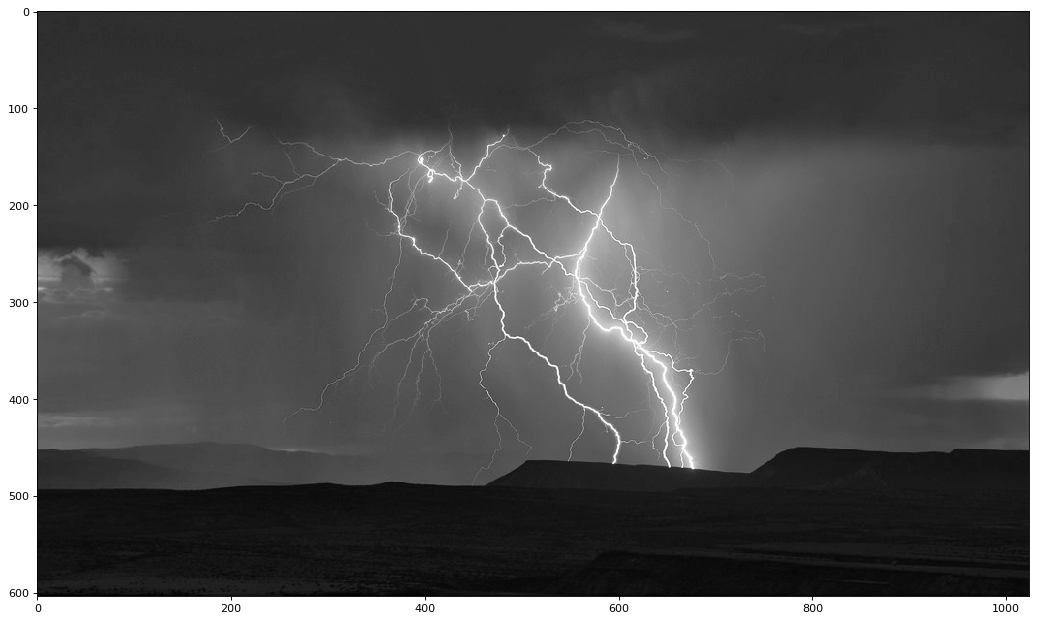

In [2]:
image = io.imread('img/lightning.jpg', as_gray=True)
plt.figure(num=None, figsize=(16, 12), dpi=80)
plt.imshow(image, cmap=plt.cm.Greys_r)

## Smooth the Test Image

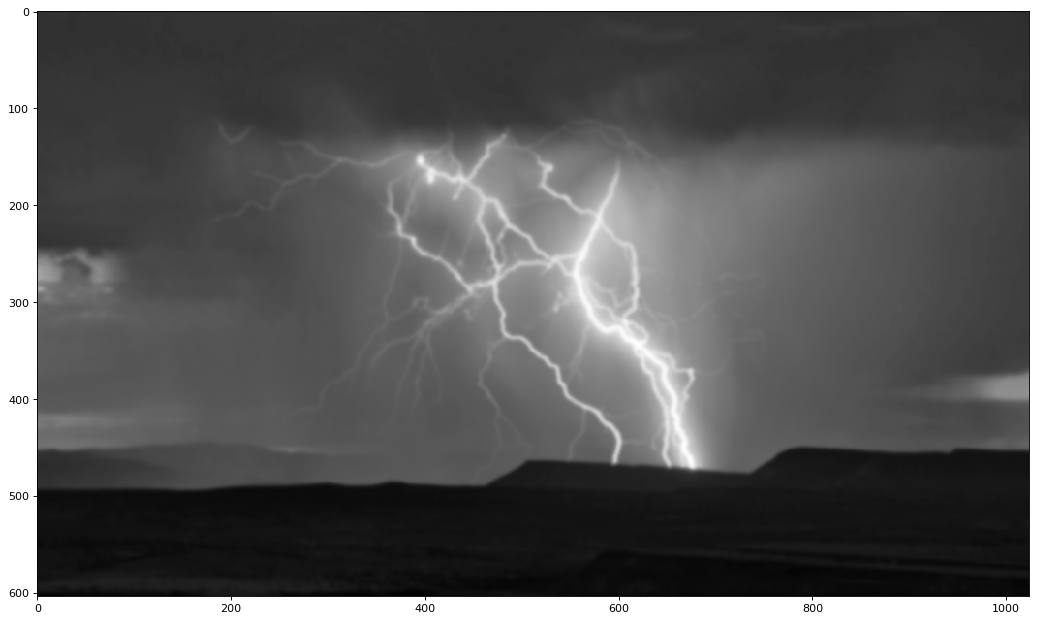

In [3]:
blurred_image = filters.gaussian(image, sigma=2**1)
plt.figure(num=None, figsize=(16, 12), dpi=80)
plt.imshow(blurred_image, cmap=plt.cm.Greys_r)
blurred_image.astype('float32').tofile('lightning_smoothed.raw')
image = blurred_image

## Look at Some Info about the Image

This will be useful later on to look to set the initial persistence threshold of the Morse-Smale Complex construction.

(604, 1024)
0.05326489785831394 0.8655970473254249


(array([1.16740e+04, 9.82550e+04, 1.90770e+04, 6.53400e+03, 1.41561e+05,
        6.72250e+04, 9.49910e+04, 5.49050e+04, 2.81960e+04, 2.07110e+04,
        1.99800e+04, 1.65580e+04, 1.02800e+04, 7.82500e+03, 5.72100e+03,
        4.44400e+03, 2.99300e+03, 2.46000e+03, 1.63100e+03, 1.02200e+03,
        6.87000e+02, 6.04000e+02, 5.96000e+02, 4.87000e+02, 7.90000e+01]),
 array([0.0532649 , 0.08575818, 0.11825147, 0.15074476, 0.18323804,
        0.21573133, 0.24822461, 0.2807179 , 0.31321119, 0.34570447,
        0.37819776, 0.41069104, 0.44318433, 0.47567762, 0.5081709 ,
        0.54066419, 0.57315747, 0.60565076, 0.63814405, 0.67063733,
        0.70313062, 0.7356239 , 0.76811719, 0.80061048, 0.83310376,
        0.86559705]),
 <a list of 25 Patch objects>)

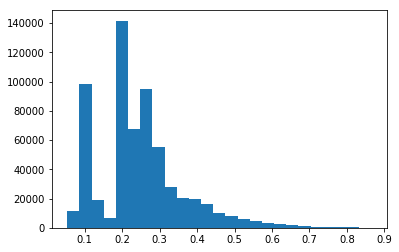

In [4]:
print(image.shape)

# To generate input file for MSCVisus:
# image.astype('float32').tofile('lightning_smoothed.raw')

print(np.min(image.flatten()), np.max(image.flatten()))
plt.hist(image.flatten(), 25)

### Hand-Picked Ground Truth Labels

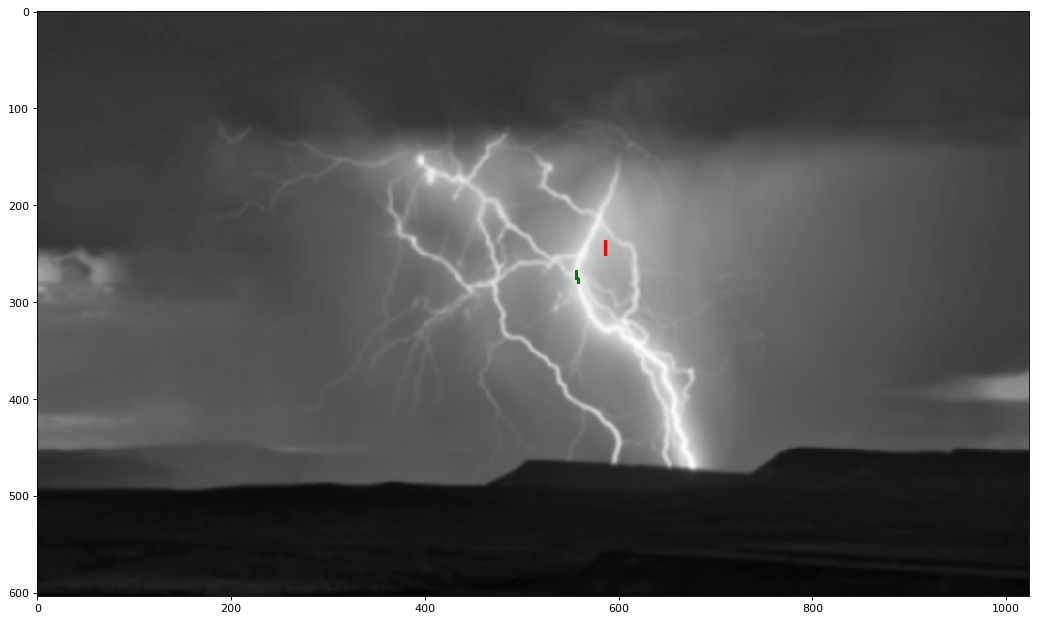

In [5]:
plt.figure(num=None, figsize=(16, 12), dpi=80)
plt.imshow(image, cmap=plt.cm.Greys_r)

lightning_samples = np.array([[556, 268],
                              [556, 269],
                              [556, 270],
                              [556, 271],
                              [556, 272],
                              [556, 273],
                              [556, 274],
                              [556, 275],
                              [557, 275],
                              [558, 276],
                              [558, 277],
                              [558, 278],
                              [556, 279]])

background_samples = np.array([[586, 237],
                               [586, 238],
                               [586, 239],
                               [586, 240],
                               [586, 241],
                               [586, 242],
                               [586, 243],
                               [586, 244],
                               [587, 245],
                               [588, 246],
                               [588, 247],
                               [588, 248],
                               [586, 249],
                               [586, 250]])

plt.scatter([556, 556, 556, 556, 556, 556, 556, 556, 557, 558, 558, 558, 558],
            [268, 269, 270, 271, 272, 273, 274, 275, 275, 276, 277, 278, 279], color='green', s=1, marker=',')

plt.scatter([586, 586, 586, 586, 586, 586, 586, 586, 586, 586, 586, 586, 586, 586],
            [237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250], color='red', s=1, marker=',')

Note, below that the order of the indices (x=col, y=row). This is important and will need to be ensured that we do the same when we construct our training data.

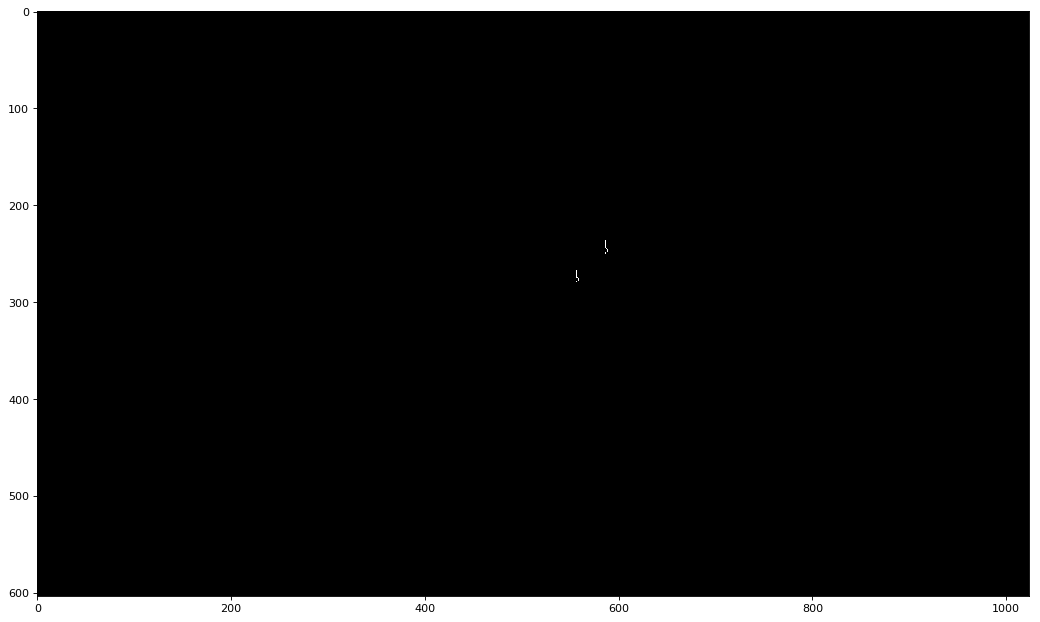

In [6]:
labeled_image = np.zeros(image.shape)

for sample in lightning_samples:
    labeled_image[sample[1], sample[0]] = 1

for sample in background_samples:
    labeled_image[sample[1], sample[0]] = 1    
    

plt.figure(num=None, figsize=(16, 12), dpi=80)
plt.imshow(labeled_image, cmap=plt.cm.Greys_r)

## Apply A Few Simple Filters

### Gaussian Blur

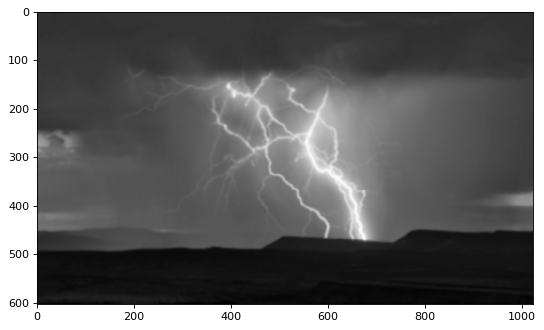

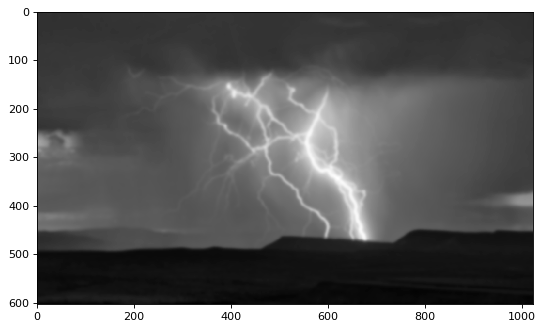

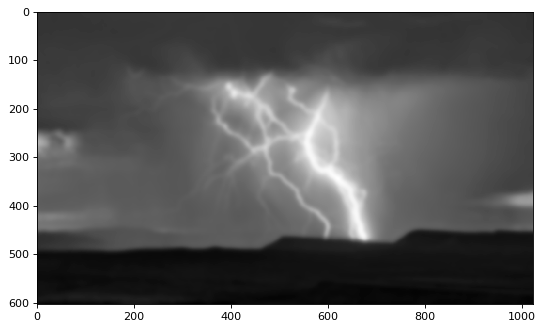

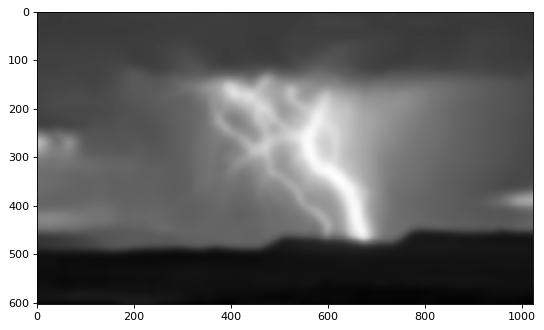

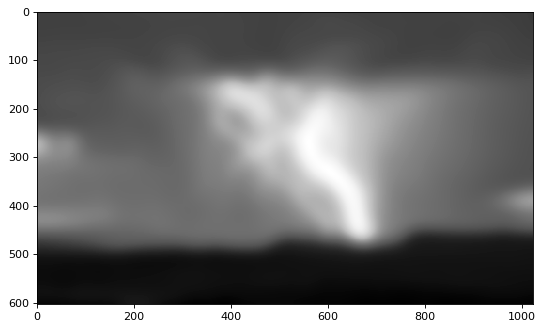

In [7]:
blur_images = []
for i in range(0,5):
    blur_images.append(filters.gaussian(image, sigma=2**i))
    
for blur_image in blur_images:
    plt.figure(num=None, figsize=(8, 6), dpi=80)
    plt.imshow(blur_image, cmap=plt.cm.Greys_r)

### Difference of Gaussians

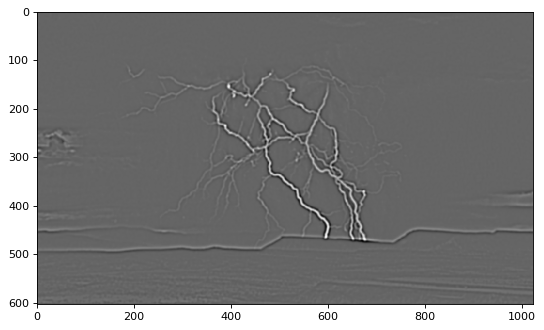

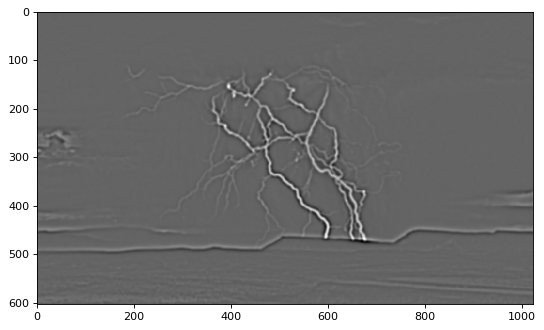

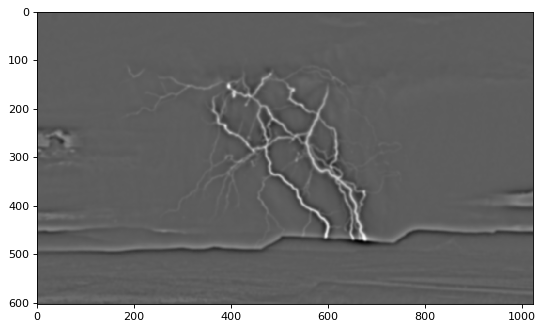

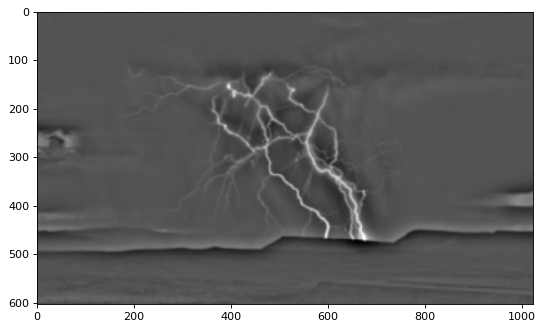

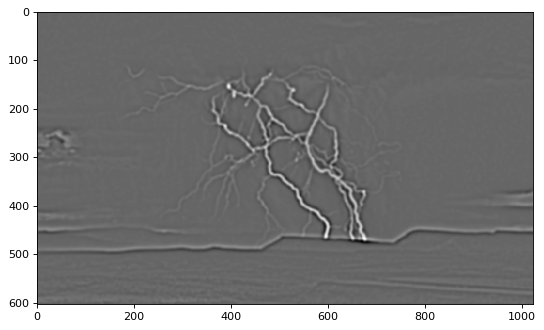

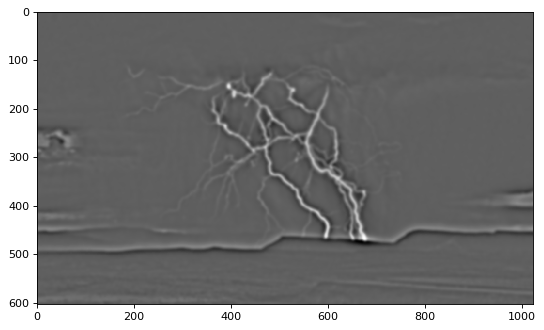

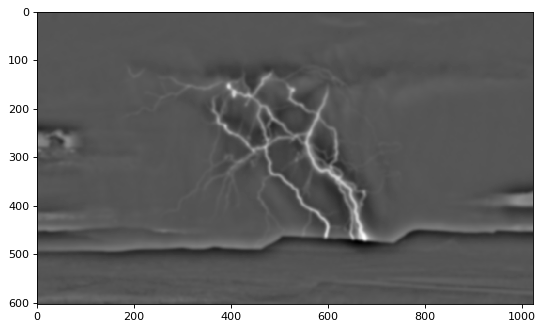

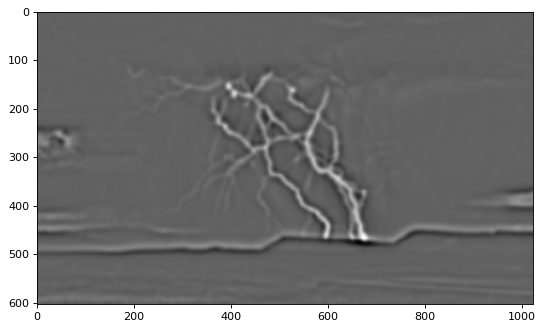

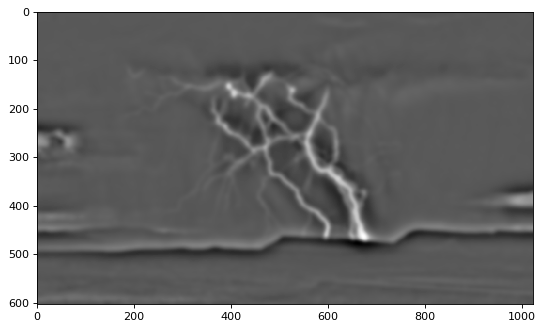

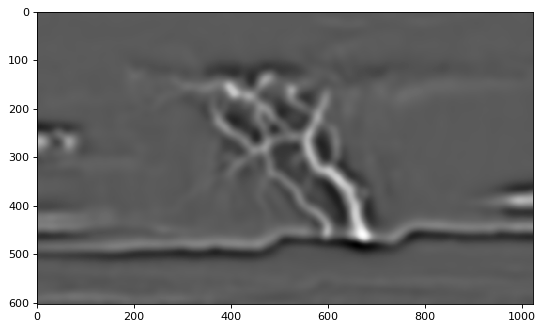

In [8]:
diff_images = []
for i, blur in enumerate(blur_images):
    for blur2 in blur_images[i+1:]:
        diff_images.append(blur-blur2)

for diff_image in diff_images:
    plt.figure(num=None, figsize=(8, 6), dpi=80)
    plt.imshow(diff_image, cmap=plt.cm.Greys_r)

### Membrane Projections

In [9]:
# Create the base kernel, a vertical column of 1s in a 19x19 matrix
membrane_kernel_size = 19
membrane_kernel = np.zeros((membrane_kernel_size, membrane_kernel_size))
membrane_kernel[:, membrane_kernel_size//2] = 1.

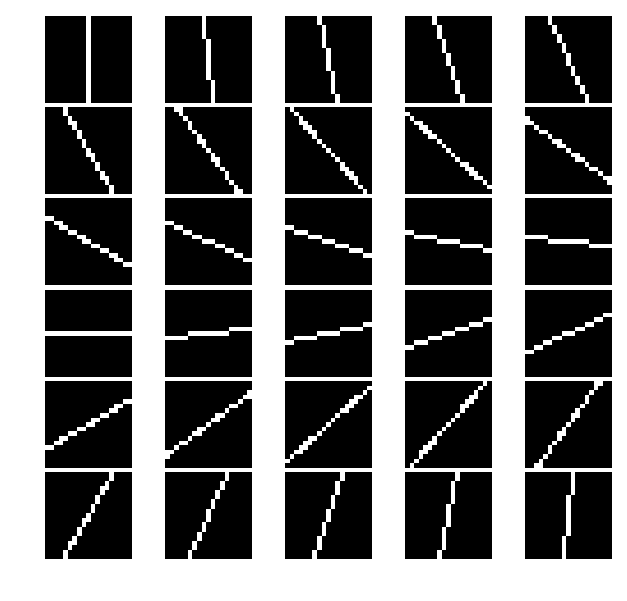

In [10]:
# Create the 30 test kernels from the base kernel and look at them to make sure that they make sense
test_kernels = []

fig, ax = plt.subplots(6, 5, figsize=(5, 6), dpi=120)
fig.subplots_adjust(left=0.0, right=1, hspace=0.05, wspace=0)
ax = ax.flatten()
for i, angle in enumerate(range(0, 180, 6)):
    test_kernels.append(transform.rotate(membrane_kernel, angle, resize=False, center=None, order=0, mode='edge', clip=True, preserve_range=True))
    ax[i].imshow(test_kernels[i], cmap=plt.cm.Greys_r)
    ax[i].axis('off')

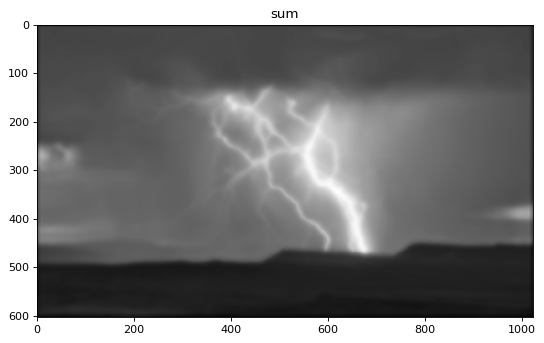

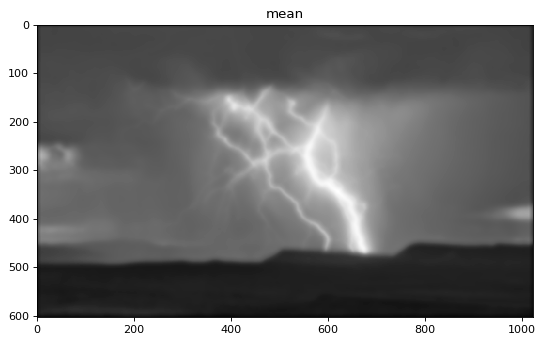

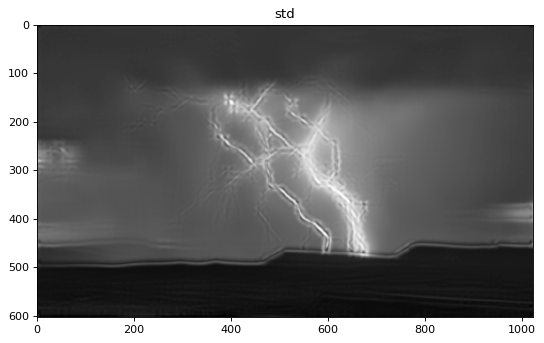

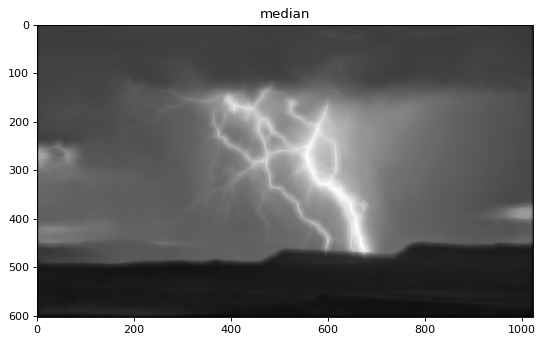

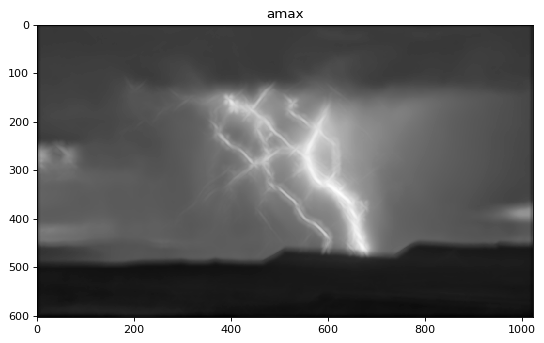

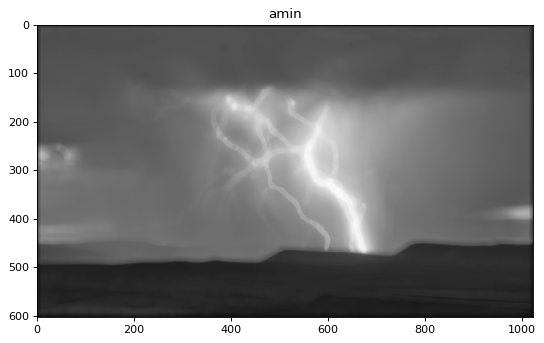

In [11]:
test_images = []
for test_kernel in test_kernels:
    test_images.append(ndimage.filters.convolve(image, test_kernel, mode='constant', cval=0))

stacked_images = np.dstack(tuple(test_images))
membrane_projection_images = []
names = []
for foo in [np.sum, np.mean, np.std, np.median, np.max, np.min]:
    membrane_projection_images.append(foo(stacked_images, axis=2))
    names.append(foo.__name__)

for title, membrane_projection_image in zip(names, membrane_projection_images):
    plt.figure(num=None, figsize=(8, 6), dpi=80)
    plt.imshow(membrane_projection_image, cmap=plt.cm.Greys_r)
    plt.gca().set_title(title)

### Sobel Filter

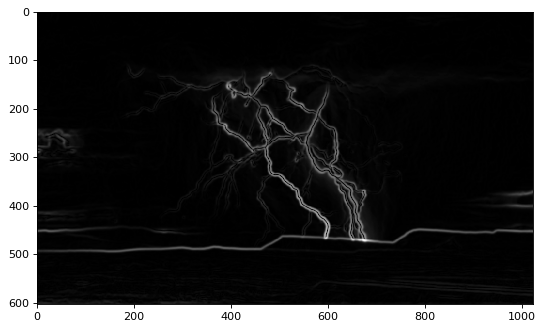

In [12]:
sobel_image = filters.sobel(image)
plt.figure(num=None, figsize=(8, 6), dpi=80)
plt.imshow(sobel_image, cmap=plt.cm.Greys_r)

### Hessian Filter

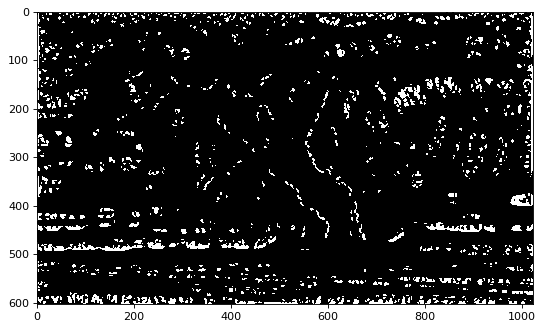

In [13]:
hessian_image = filters.hessian(image)
plt.figure(num=None, figsize=(8, 6), dpi=80)
plt.imshow(hessian_image, cmap=plt.cm.Greys_r)

### Mean Filter

/home/maljovec/anaconda3/envs/regulus/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


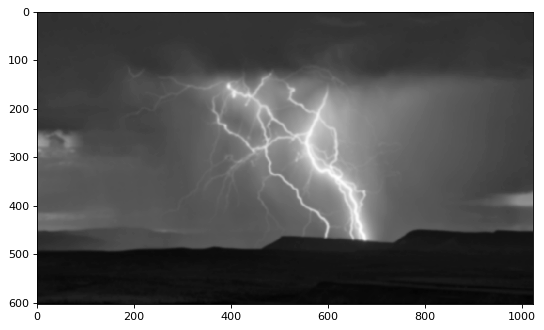

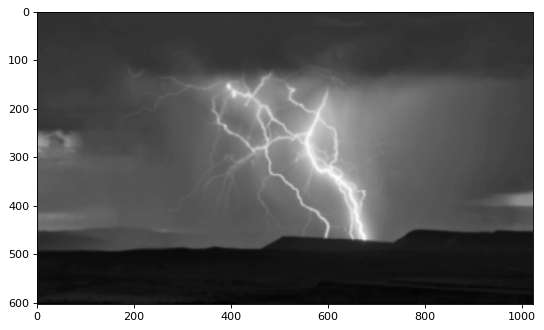

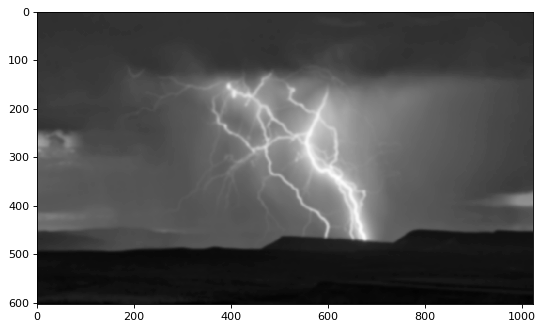

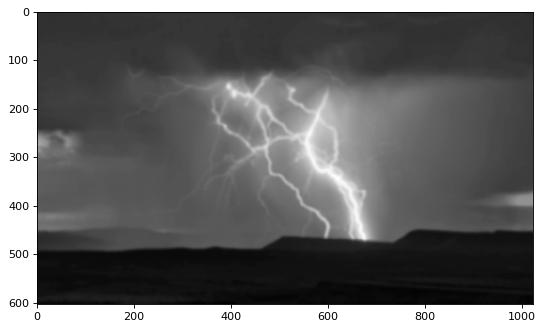

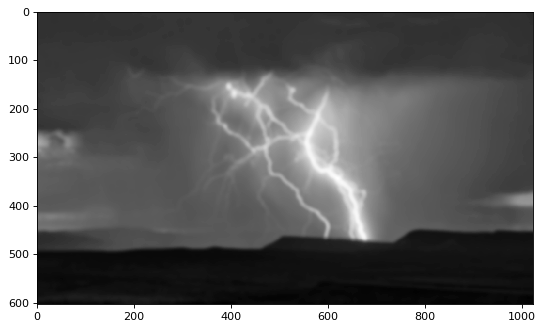

In [14]:
mean_images = []
for i in range(1,6):
    mean_images.append(filters.rank.mean(image, selem=morphology.disk(i)))

for mean_image in mean_images:
    plt.figure(num=None, figsize=(8, 6), dpi=80)
    plt.imshow(mean_image, cmap=plt.cm.Greys_r)

### Variance Filter

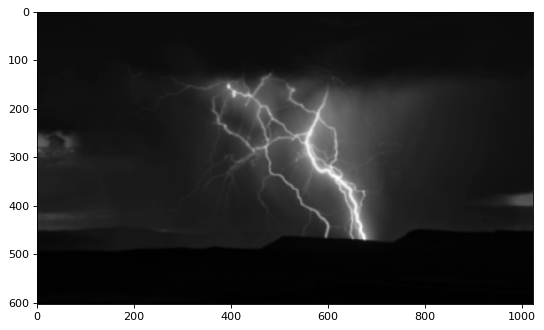

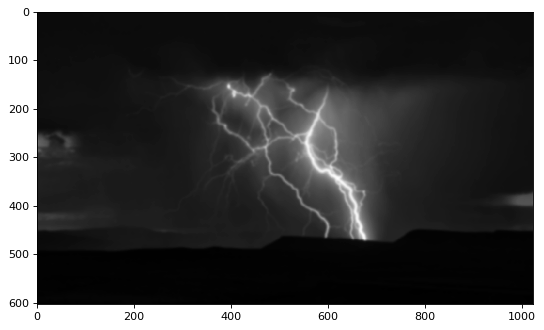

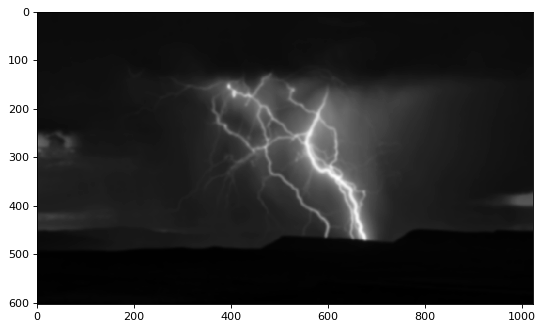

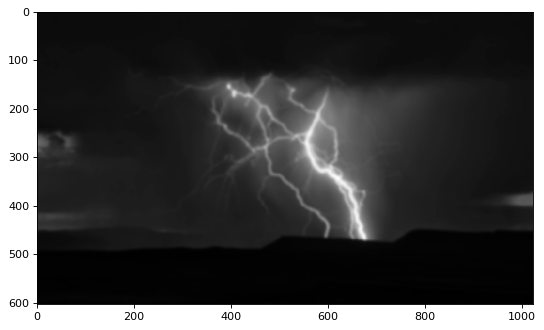

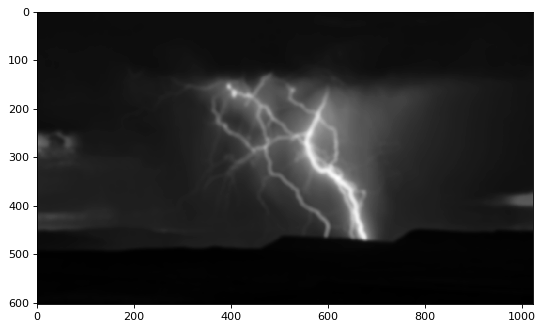

In [15]:
variance_images = []
for mean_image in mean_images:
    variance_images.append(np.power(image-mean_image,2))
    
for variance_image in variance_images:
    plt.figure(num=None, figsize=(8, 6), dpi=80)
    plt.imshow(variance_image, cmap=plt.cm.Greys_r)

### Median Filter

/home/maljovec/anaconda3/envs/regulus/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


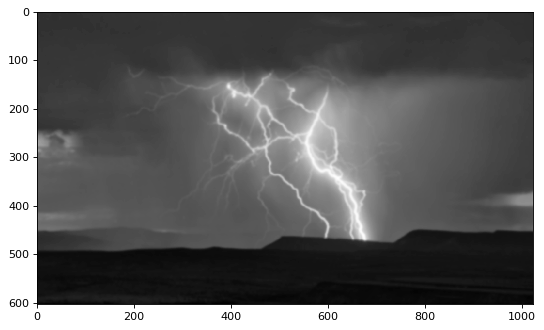

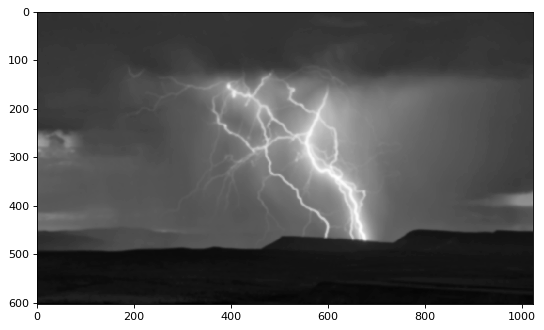

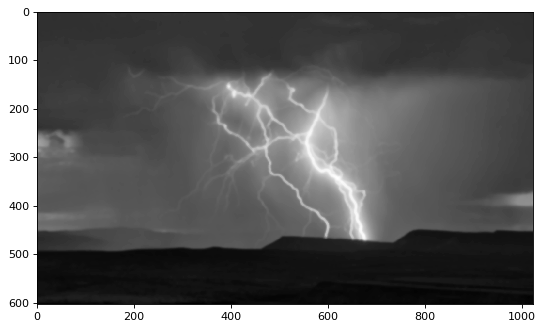

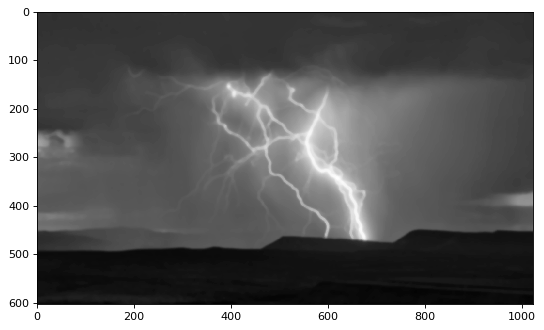

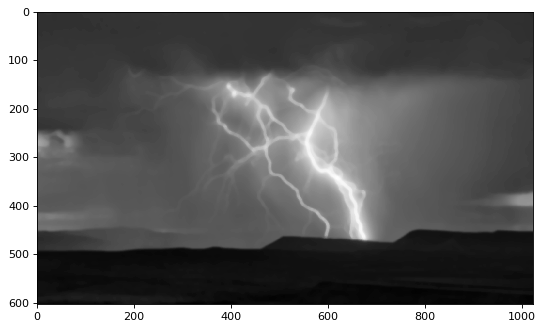

In [16]:
median_images = []
for i in range(1,6):
    median_images.append(filters.rank.median(image, selem=morphology.disk(i)))

for median_image in median_images:
    plt.figure(num=None, figsize=(8, 6), dpi=80)
    plt.imshow(median_image, cmap=plt.cm.Greys_r)

### Minimum Filter

/home/maljovec/anaconda3/envs/regulus/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


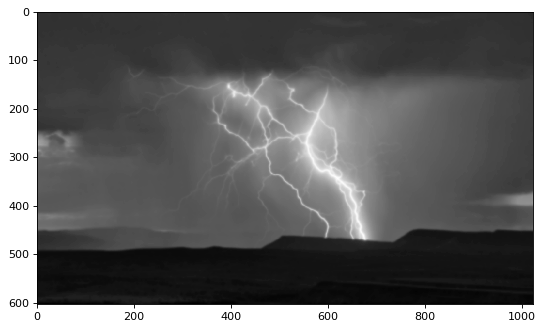

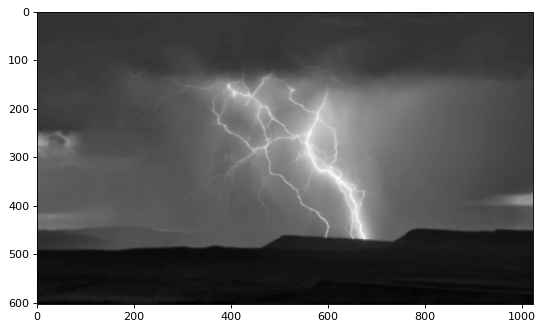

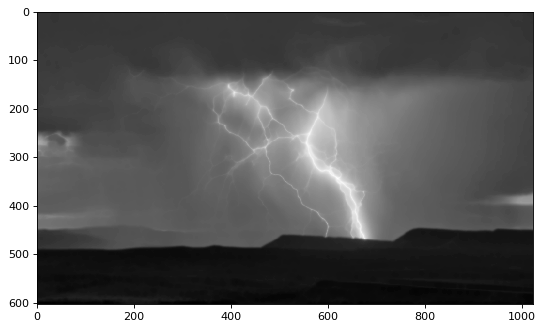

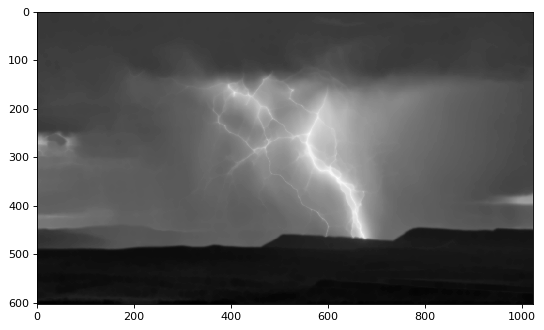

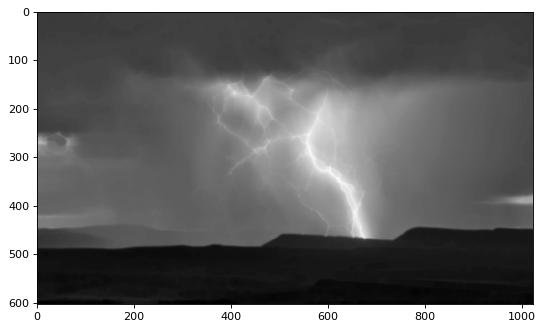

In [17]:
minimum_images = []
for i in range(1,6):
    minimum_images.append(filters.rank.minimum(image, selem=morphology.disk(i)))

for minimum_image in minimum_images:
    plt.figure(num=None, figsize=(8, 6), dpi=80)
    plt.imshow(minimum_image, cmap=plt.cm.Greys_r)

### Maximum Filter

/home/maljovec/anaconda3/envs/regulus/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


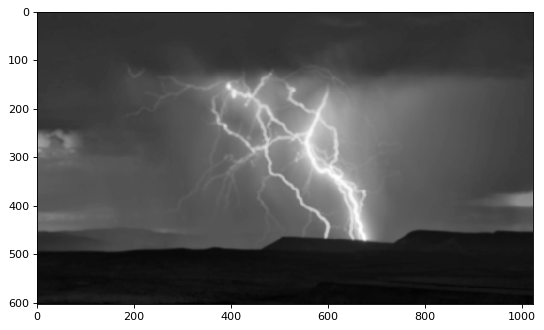

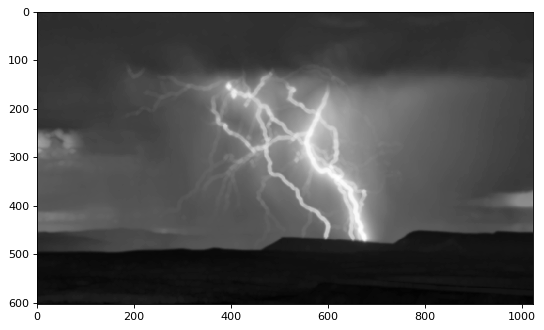

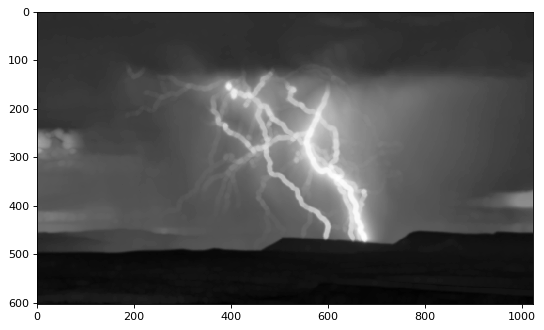

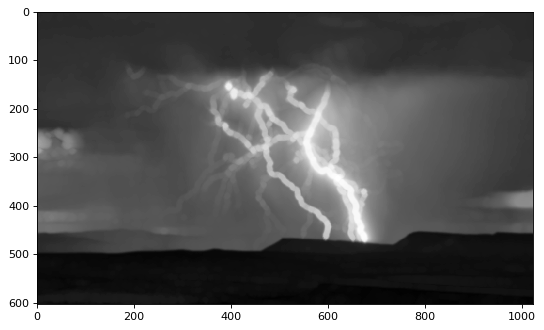

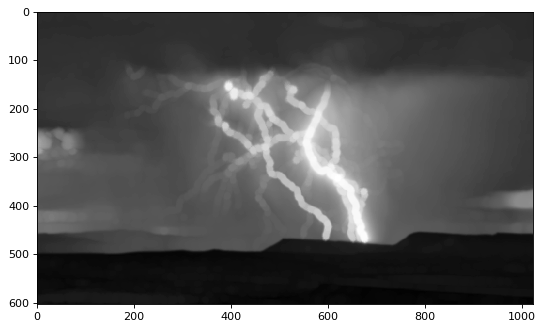

In [18]:
maximum_images = []
for i in range(1,6):
    maximum_images.append(filters.rank.maximum(image, selem=morphology.disk(i)))

for maximum_image in maximum_images:
    plt.figure(num=None, figsize=(8, 6), dpi=80)
    plt.imshow(maximum_image, cmap=plt.cm.Greys_r)

### Anisotropic Diffusion

In [19]:
# TODO

### Bilateral Filter

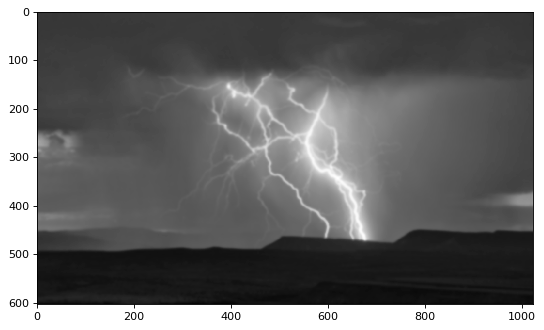

In [20]:
# TODO ensure parameters match the Weka specification (I'm just using the defaults for now)
bilateral_image = restoration.denoise_bilateral(image, win_size=None, sigma_color=None, sigma_spatial=1, bins=10000, mode='constant', cval=0, multichannel=False)
plt.figure(num=None, figsize=(8, 6), dpi=80)
plt.imshow(bilateral_image, cmap=plt.cm.Greys_r)

### Lipschitz Filter

In [21]:
# TODO


### Kuwahara Filter

In [22]:
# TODO


### Gabor Filter

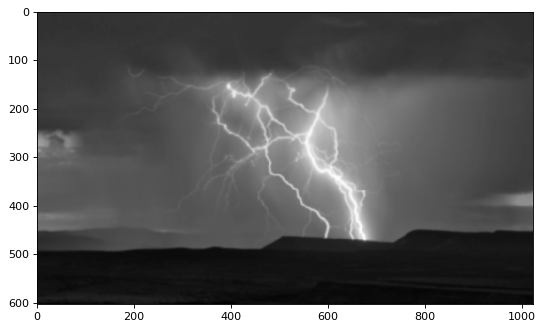

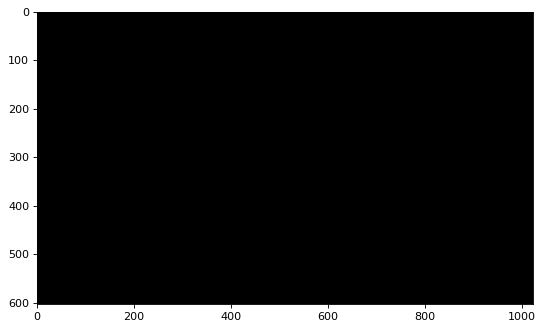

In [23]:
# TODO: learn more about this filter and what values to use for frequency.
gabor_real_image, gabor_imaginary_image = filters.gabor(image, frequency=3, theta=0, bandwidth=1, sigma_x=None, sigma_y=None, n_stds=3, offset=0, mode='reflect', cval=0)
plt.figure(num=None, figsize=(8, 6), dpi=80)
plt.imshow(gabor_real_image, cmap=plt.cm.Greys_r)

plt.figure(num=None, figsize=(8, 6), dpi=80)
plt.imshow(gabor_imaginary_image, cmap=plt.cm.Greys_r)

### Derivative Filters

In [24]:
# TODO

### Laplacian Filter

/home/maljovec/anaconda3/envs/regulus/lib/python3.7/site-packages/skimage/restoration/uft.py:447: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  impr[([slice(1, 2)] * ndim)] = 2.0 * ndim


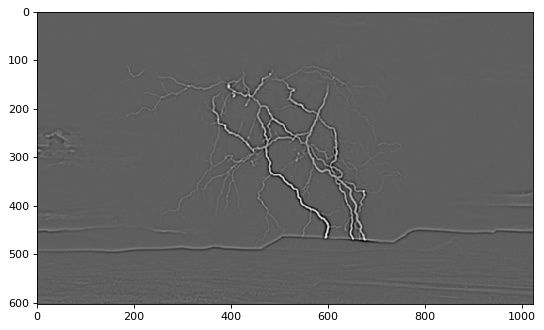

In [25]:
laplace_image = filters.laplace(image, ksize=3)

plt.figure(num=None, figsize=(8, 6), dpi=80)
plt.imshow(laplace_image, cmap=plt.cm.Greys_r)

### Structure Filter

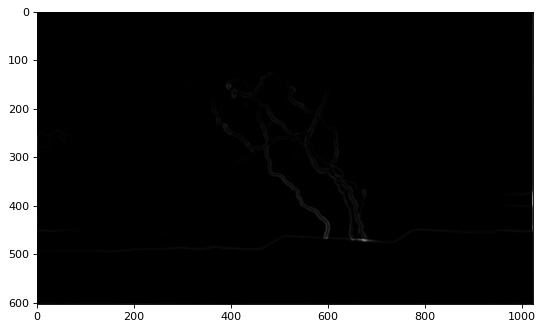

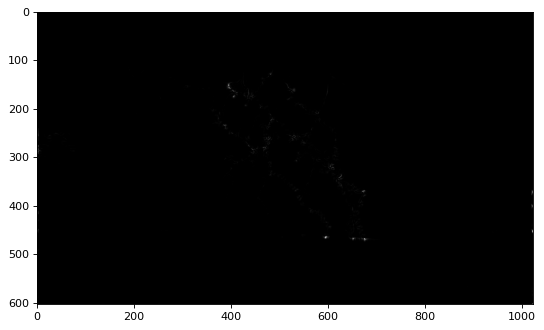

In [26]:
structure_tensor = feature.structure_tensor(image, sigma=1, mode='constant', cval=0)
largest_eig_image = np.zeros(shape=image.shape)
smallest_eig_image = np.zeros(shape=image.shape)
for row in range(structure_tensor[0].shape[0]):
    for col in range(structure_tensor[0].shape[1]):
        Axx = structure_tensor[0][row, col]
        Axy = structure_tensor[1][row, col]
        Ayy = structure_tensor[2][row, col]
        eigs = np.linalg.eigvals([[Axx, Axy], [Axy, Ayy]])
        largest_eig_image[row, col] = np.max(eigs)
        smallest_eig_image[row, col] = np.min(eigs)
        
plt.figure(num=None, figsize=(8, 6), dpi=80)
plt.imshow(largest_eig_image, cmap=plt.cm.Greys_r)

plt.figure(num=None, figsize=(8, 6), dpi=80)
plt.imshow(smallest_eig_image, cmap=plt.cm.Greys_r)

### Entropy Filter

/home/maljovec/anaconda3/envs/regulus/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


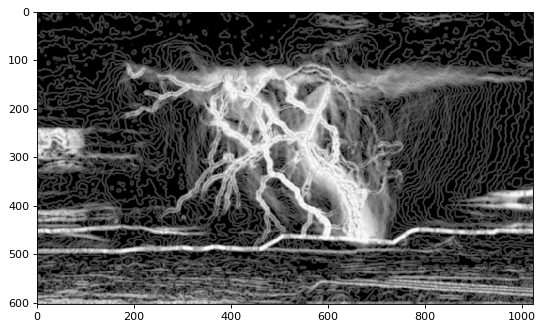

In [27]:
entropy_image = filters.rank.entropy(image, selem=morphology.disk(3))

plt.figure(num=None, figsize=(8, 6), dpi=80)
plt.imshow(entropy_image, cmap=plt.cm.Greys_r)

### Neighbors

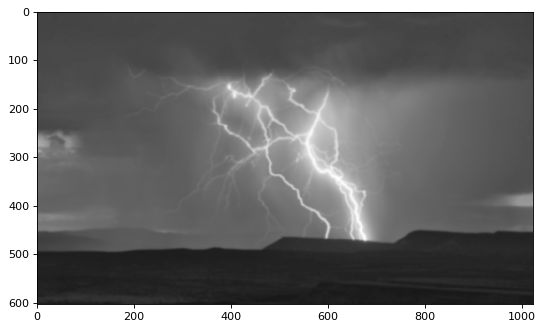

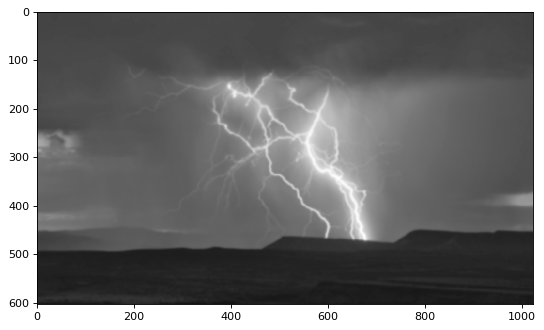

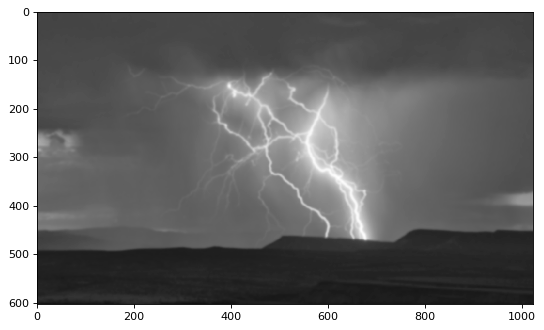

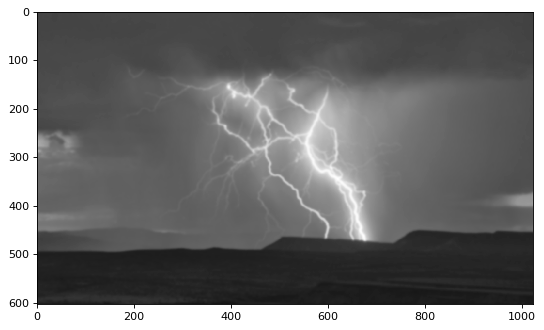

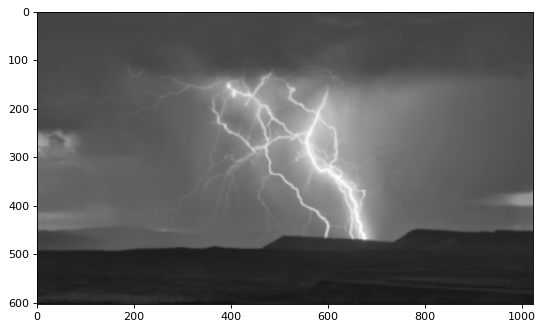

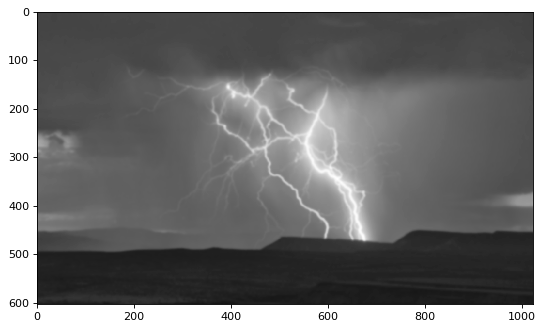

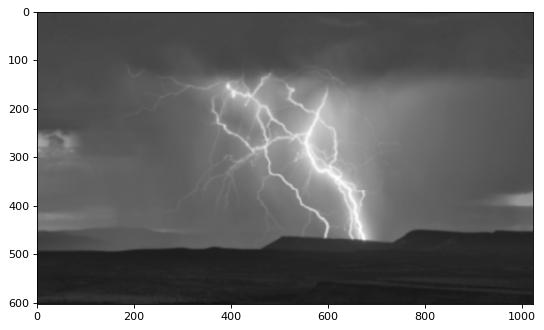

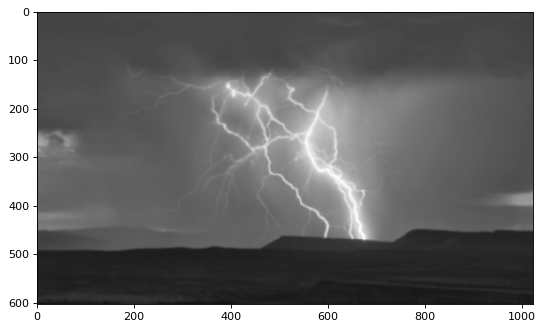

In [28]:
neighbor_images = []
directions = [(-1,-1), (-1, 0), (-1, 1), (0, -1), (0, 1), (1, -1), (1, 0), (1, 1)]
sigma = 1

for t in directions:
    for sigma in range(1, sigma+1):
        tform = transform.SimilarityTransform(scale=1, rotation=0, translation=tuple([sigma*val for val in t]))
        neighbor_images.append(transform.warp(image, tform))
        
for neighbor_image in neighbor_images:
    plt.figure(num=None, figsize=(8, 6), dpi=80)
    plt.imshow(neighbor_image, cmap=plt.cm.Greys_r)

## Massage the Input

In [29]:
# First grab all of the single image variables
growing_tuple = (image,
                 sobel_image,
                 hessian_image,
                 bilateral_image,
                 gabor_real_image,
                 laplace_image,
                 largest_eig_image,
                 smallest_eig_image,
                 entropy_image)

# Then add all of the multiple image variables
growing_tuple += tuple(diff_images)
growing_tuple += tuple(mean_images)
growing_tuple += tuple(variance_images)
growing_tuple += tuple(median_images)
growing_tuple += tuple(minimum_images)
growing_tuple += tuple(maximum_images)
growing_tuple += tuple(neighbor_images)
growing_tuple += tuple(membrane_projection_images)

compiled_data = np.dstack(growing_tuple)
print(compiled_data.shape)

(604, 1024, 58)


In [30]:
# Note the use of the backwards indexing here, the y values of "samples" variables are actually the rows of the images
class_lightning = compiled_data[lightning_samples[:, 1], lightning_samples[:, 0], :]
class_background = compiled_data[background_samples[:, 1], background_samples[:, 0], :]
train_x = np.vstack((class_lightning, class_background))
train_y = np.hstack((np.ones(class_lightning.shape[0]), np.zeros(class_background.shape[0])))

## Build a Random Forest

In [31]:
classifiers = {}
classifiers['random_forest'] = ensemble.RandomForestClassifier(n_estimators=10,
                                                               criterion='gini',
                                                               max_depth=None,
                                                               min_samples_split=2,
                                                               min_samples_leaf=1,
                                                               min_weight_fraction_leaf=0.0,
                                                               max_features='auto',
                                                               max_leaf_nodes=None,
                                                               min_impurity_decrease=0.0,
                                                               min_impurity_split=None,
                                                               bootstrap=True,
                                                               oob_score=False,
                                                               n_jobs=1,
                                                               random_state=None,
                                                               verbose=0,
                                                               warm_start=False,
                                                               class_weight=None)

classifiers['random_forest'].fit(train_x, train_y)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

## Build an SVM

In [32]:
svc = svm.SVC(C=1.0,
              kernel='rbf',
              gamma='auto',
              coef0=0.0,
              shrinking=True,
              probability=False,
              tol=0.001,
              cache_size=2048,
              class_weight=None,
              verbose=False,
              max_iter=-1,
              decision_function_shape='ovr',
              random_state=None)
param_grid = {'C': [1e-3, 1e-1, 1e1, 1e3, 1e5]}

classifiers['svm'] = model_selection.GridSearchCV(svc, param_grid)
classifiers['svm'].fit(train_x, train_y)

GridSearchCV(cv=None, error_score='raise',
       estimator=SVC(C=1.0, cache_size=2048, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [0.001, 0.1, 10.0, 1000.0, 100000.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

## Build a K-Nearest Neighbor Classifier

In [33]:
knn = neighbors.KNeighborsClassifier(n_neighbors=25,
                                     weights='uniform', 
                                     algorithm='auto', 
                                     leaf_size=30, 
                                     p=2, 
                                     metric='minkowski', 
                                     metric_params=None, 
                                     n_jobs=1)
knn.fit(train_x, train_y)
classifiers['knn'] = knn

## Build a Logistic Regression Classifier

In [34]:
classifiers['logit'] = linear_model.LogisticRegression(penalty='l2',
                                                       dual=False,
                                                       tol=0.0001,
                                                       C=1.0,
                                                       fit_intercept=True,
                                                       intercept_scaling=1,
                                                       class_weight=None,
                                                       random_state=None,
                                                       solver='liblinear',
                                                       max_iter=100,
                                                       verbose=0,
                                                       warm_start=False,
                                                       n_jobs=1)
classifiers['logit'].fit(train_x, train_y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

## Build Some Neural Network Classifiers

In [35]:
classifiers['nnet_flat'] = neural_network.MLPClassifier(hidden_layer_sizes=(100, ),
                                                        activation='relu',
                                                        solver='adam',
                                                        alpha=0.0001,
                                                        batch_size='auto',
                                                        learning_rate='constant',
                                                        learning_rate_init=0.001,
                                                        power_t=0.5,
                                                        max_iter=200,
                                                        shuffle=True,
                                                        random_state=None,
                                                        tol=0.0001,
                                                        verbose=False,
                                                        warm_start=False,
                                                        momentum=0.9,
                                                        nesterovs_momentum=True,
                                                        early_stopping=False,
                                                        validation_fraction=0.1,
                                                        beta_1=0.9,
                                                        beta_2=0.999,
                                                        epsilon=1e-08)
classifiers['nnet_flat'].fit(train_x, train_y)

classifiers['nnet_deep'] = neural_network.MLPClassifier(hidden_layer_sizes=(10, 10),
                                                        activation='relu',
                                                        solver='adam',
                                                        alpha=0.0001,
                                                        batch_size='auto',
                                                        learning_rate='constant',
                                                        learning_rate_init=0.001,
                                                        power_t=0.5,
                                                        max_iter=200,
                                                        shuffle=True,
                                                        random_state=None,
                                                        tol=0.0001,
                                                        verbose=False,
                                                        warm_start=False,
                                                        momentum=0.9,
                                                        nesterovs_momentum=True,
                                                        early_stopping=False,
                                                        validation_fraction=0.1,
                                                        beta_1=0.9,
                                                        beta_2=0.999,
                                                        epsilon=1e-08)
classifiers['nnet_deep'].fit(train_x, train_y)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(10, 10), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

## Visualize the Resulting Classifiers

In [ ]:
for name, classifier in classifiers.items():
    flattened_data = compiled_data.reshape(-1, compiled_data.shape[-1])
    predicted_labels = classifier.predict(flattened_data)
    predicted_labels = predicted_labels.reshape(compiled_data.shape[0], compiled_data.shape[1])

    plt.figure(num=None, figsize=(8, 6), dpi=80)
    plt.imshow(predicted_labels, cmap=plt.cm.Greys_r)
    plt.title(name)

In [ ]:
test_msc = MSC()
test_msc.read_from_file("lightning_smoothed.raw")

In [ ]:
print(len(test_msc.arcs))

In [ ]:
plt.figure(num=None, figsize=(16, 12), dpi=80)
plt.imshow(image, cmap=plt.cm.Greys_r)

test_image = np.copy(image)
halfway = len(test_msc.arcs)//2

for a in test_msc.arcs:
    points = np.array(a.line)
    plt.scatter(points[:, 0], points[:, 1], color='#FFCC99', s=1, marker=',')
#         print(np.min(points), np.max(points))

for node in test_msc.nodes.values():
    x, y = node.xy
    plt.scatter(x, y, color="#FF0000", s=4, marker=',' )

# plt.gca().set_xlim(0, 604)
# plt.gca().set_ylim(604, 0)